# Pharmacokinetic Analysis

SEOYEON CHOI  
6/9/23

> Pharmacokinetic Analysis

Ref: [Winnonlin Guide
8.3](https://onlinehelp.certara.com/phoenix/8.3/responsive_html5_!MasterPage!/WinNonlin%20User%27s%20Guide.pdf),
[Design and Analysis of Bioavailability and Bioequivalence
Studies](https://books.google.co.kr/books?hl=ko&lr=&id=KtKJFGJeV3MC&oi=fnd&pg=PP1&dq=Design+and+analysis+of+bioavailability+and+bioequivalence+studies+,+Third+edition,+Chapman+%26+Hall&ots=scXq3Y2TPA&sig=S_FTX9fEmubxjz2RlouUnbWL7f0#v=onepage&q=Design%20and%20analysis%20of%20bioavailability%20and%20bioequivalence%20studies%20%2C%20Third%20edition%2C%20Chapman%20%26%20Hall&f=false),
[2×k 교차설계법에서 생물학적 동등성 추가시험의 통계적
절차](http://koreascience.or.kr/article/JAKO201436351074280.pdf),
[식품의약품안전처 의약품 동등성 시험
기준](https://www.law.go.kr/LSW/admRulLsInfoP.do?admRulSeq=2100000129149)

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz # AUC
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import copy
import statsmodels.api as sm
import statsmodels.formula.api as smf

# PK Analysis

## Generic Medicine

-   a generic medicine works in the same way and provides the same
    clinical benefit as the brand-name medicine.[1]

-   특허기간이 만료된 오리지널 의약품과 주성분, 함량 및 제형이 동일하게
    복제된 제네릭 의약품은 생물학적 동등성 (이하‘생동성’이라 한다)시험을
    통해 오리지널 의약품과 약효가 동등하다는 것을 입증 하면 시장에
    진입할 수 있다.[2]

-   제네릭 의약품을 승인 받기 위해 생동성 시험을 거쳐야 한다

## Bioequivalent

-   Drug companies must submit an abbreviated new drug application
    (ANDA) to FDA for approval to market a generic drug that is the same
    as (or bioequivalent to) the brand product[3]

-   생동성 시험은 제재학적으로 동등한 두 제제의 동등성 입증을 위해
    실시하는 샐체내 실험으로, 통계학적으로 두 제제의 생체이용률의
    유사성을 비교하는 시험을 의미한다.(우화형 and 박상규 2014)

## Parameter

-   $AUC_t$
    -   Area under the curve from the time of dosing to the time of the
        last measurable (positive) concentratio
    -   약물 투여 시점부터 마지막으로 측정 가능한 (양수인) 농도까지의
        면적인 (Area Under the Curve, AUC)는 약동학에서 사용되는
        일반적인 파라미터
    -   시간에 따른 약물 노출의 범위를 추정하는 데 사용
    -   해당 기간 동안 혈중에서의 누적된 약물 농도를 나타냄
-   $C_{max}$ - Maximum observed concentration, occurring at time Tmax,
    as defined above.
    -   $T_{max}$에서의 최대 농도
-   $T_{max}$
    -   Time of maximum observed concentration. For non-steady-state
        data, the entire curve is considered. If the maximum observed
        concentration is not unique, then the first maximum is used.
    -   최대 혈중 농도가 관찰된 시간
    -   유일한 값이 아닌 경우 첫번재 값 사용
-   $\lambda_z$
    -   First-order rate constant associated with the terminal
        (log-linear) portion of the curve. Estimated by linear
        regression of time vs. log concentration
    -   곡선의 말단(로그-선형) 부분과 관련된 1차 속도상수는 시간 대 로그
        농도의 선형 회귀를 통해 추정
    -   곡선의 로그-선형 영역에서 시간과 로그 농도 간의 선형 관계를
        분석하여 얻어진 1차 속도상수
    -   약동학 데이터의 로그-선형 부분에서 시간 대 로그 농도의 관계를
        선형 회귀하여 추정된 1차 속도상수를 의미.
-   $ln(2)/\lambda_z$
    -   Terminal half-life
-   $Tau$
    -   Available in the Dosing Used results worksheet for steady-state
        data. The (assumed equal) dosing interval for steady-state data.
    -   반복 투여하는 연구에서 반복투여하는 간격
    -   예) 12시간 간격으로 하루에 두 번 투여시, tau = 12
-   $AUC_{TAU}$
    -   The partial area from dosing time to dosing time plus Tau. See
        “Partial area calculation”
    -   for information on how it is computed
    -   tau간격 별로 혈중 농도 곡선 하 면적.

\-$\text{ Swing}$: Cmax – Cmn/Cmin

\-$\text{ Fluctuation}$

-   100(Cmax – Cmin)/Cavg
-   where Cmin and Cmax were obtained between dosing time and dosing
    time plus Tau
-   약물 농도의 최소값($C_{min}$)과 최대값($C_{max}$) 사이의 변동을 약물
    투여 간격 내에서 평균 농도($C_{avg}$)에 대한 백분율로 나타내는
    약동학적 파라미터 .

약동학 파라메터 산출 프로그램 윈놀린 가이드 참고[4]

-   page 146 정도부터 파라메터 설명 및 계산법 확인

아래는 식품의약품 안전처 규칙 내용 중 일부

-   AUCt: 투약시간부터 최종 혈중농도 정량 시간 t까지의
    혈중농도-시간곡선하면적
-   AUC∞ : 투약시간부터 무한시간까지의 혈중농도-시간곡선하면적 (AUC∞ =
    AUCt + Ct/λZ
-   Ct : 최종정량농도
-   λZ : 말단 소실 정수
-   AUCt/AUC∞ : AUCt의 AUC대한 비
-   t1/2β : 소실 반감기
-   AUCτ : 정상상태의 투여간격τ중의 혈중농도-시간 곡선하면적
-   Cmax :최고혈중농도
-   Css,max정상상태의 최고혈중농도
-   Css,m: 정상상태의 최저혈중농도

**동등성 기준 : Tmax를 제외한 대조약과 시험약의 비교평가항목치를
로그변환하여 통계처리 하였을 때, 로그변환한 평균치 차의 90% 신뢰구간이
log 0.8에서 log 1.25 이내이어야 한다**

## 2 x 2 Crossover Design

현재 식품의약품 안전처에서는 두 제제의 생동성 평가 방법으로 2 x 2
교차설계법을 이용하여 두 제제의 생체이용률의 평균을 비교하는 방법 사용

|            | Period 1  | Period 2  |
|:----------:|:---------:|:---------:|
| Sequence 1 | Reference |   Test    |
| Sequence 2 |   Test    | Reference |

$$y_{jkl} = \mu + g_j + S_{l(j)} + p_k + \pi_{jk} + \epsilon_{jkl}$$

$$j = 1,2; k = 1,2; l=1,2, \dots, n_{1j}$$

$$S_{l(j)} \sim iid N(0,\sigma^2_s) , \epsilon_{jkl} \sim iid N(0, \sigma^2_\epsilon)$$

### 혈중 농도 곡선 예시

[1] https://www.fda.gov/drugs/frequently-asked-questions-popular-topics/generic-drugs-questions-answers

[2] 식품의약품안전처 의약품 동등성 시험 기준

[3] https://www.fda.gov/drugs/frequently-asked-questions-popular-topics/generic-drugs-questions-answers

[4] https://onlinehelp.certara.com/phoenix/8.3/responsive_html5\_!MasterPage!/WinNonlin%20User%27s%20Guide.pdf

In [2]:
_seq = ['1'] * 18 + ['2'] * 18
random.shuffle(_seq)

In [3]:
seq = _seq.copy()

In [4]:
prd = ['1', '2']

In [5]:
# Define the two-compartment model function
def two_compartment_model(t, ka, ke, Vc, Vp, dose):
    Cp = dose / (Vc + Vp) * (ka / (ka - ke)) * (np.exp(-ke * t) - np.exp(-ka * t))
    return Cp

In [6]:
# Time range
t = np.linspace(0, 24, 20)  # Generate 100 time points from 0 to 24 hours

In [7]:
# Number of subjects
n_subjects = 36

In [8]:
# Subject-specific pharmacokinetic parameter values
ka_values = np.random.uniform(0.2, 0.8, n_subjects)   # Elimination rate constant (1/hour)
ke_values = np.random.uniform(0.05, 0.15, n_subjects)  # Absorption rate constant (1/hour)
Vc_values = np.random.uniform(8, 12, n_subjects)      # Central volume of distribution (L)
Vp_values = np.random.uniform(3, 7, n_subjects)       # Peripheral volume of distribution (L)
dose = 100  # Dose (mg)

Conc1=[]
# Calculate and plot the pharmacokinetic concentration profile for each subject
for i in range(n_subjects):
    ka = ka_values[i]
    ke = ke_values[i]
    Vc = Vc_values[i]
    Vp = Vp_values[i]
    Sequence=seq[i]
    period = prd[0]
    Cp = two_compartment_model(t, ka, ke, Vc, Vp, dose)
    Conc1.append(Cp)

In [9]:
# Subject-specific pharmacokinetic parameter values
ka_values = np.random.uniform(0.2, 0.8, n_subjects)   # Elimination rate constant (1/hour)
ke_values = np.random.uniform(0.05, 0.15, n_subjects)  # Absorption rate constant (1/hour)
Vc_values = np.random.uniform(8, 12, n_subjects)      # Central volume of distribution (L)
Vp_values = np.random.uniform(3, 7, n_subjects)       # Peripheral volume of distribution (L)
dose = 100  # Dose (mg)

Conc2=[]
# Calculate and plot the pharmacokinetic concentration profile for each subject
for i in range(n_subjects):
    ka = ka_values[i]
    ke = ke_values[i]
    Vc = Vc_values[i]
    Vp = Vp_values[i]
    Sequence=seq[i]
    period = prd[1]
    Cp = two_compartment_model(t, ka, ke, Vc, Vp, dose)
    Conc2.append(Cp)

Text(0, 0.5, 'Concentration (mg/L)')

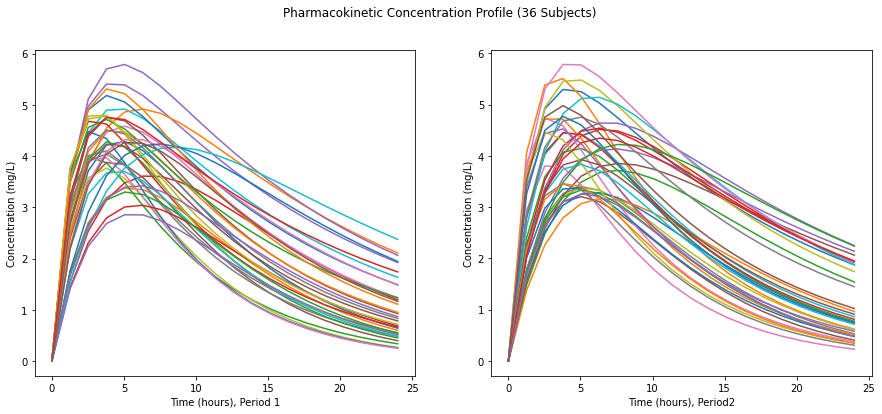

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Pharmacokinetic Concentration Profile (36 Subjects)')
for i in range(n_subjects):
    ax1.plot(t,Conc1[i])
    ax2.plot(t,Conc2[i])
ax1.set_xlabel('Time (hours), Period 1')
ax1.set_ylabel('Concentration (mg/L)')
ax2.set_xlabel('Time (hours), Period2')
ax2.set_ylabel('Concentration (mg/L)')

사다리꼴 공식으로 AUC 계산

In [11]:
auc=[]
# AUC 계산
for i in range(n_subjects):
    auc.append(trapz(Conc1, t))

auc[1]

array([56.95045738, 47.86409131, 42.21622527, 59.539426  , 86.67551908,
       47.16716698, 69.1238562 , 48.31886351, 41.10456731, 77.54870044,
       44.17471182, 84.86979417, 51.38750987, 56.38187092, 93.31926042,
       64.86536492, 41.39841529, 49.34549501, 55.17694992, 47.80196397,
       77.1173659 , 62.99088402, 67.81589046, 45.75082563, 41.08144901,
       57.4092617 , 70.38694013, 60.65264211, 59.20130041, 78.037517  ,
       75.13235504, 73.39727457, 45.94199314, 76.49863041, 52.37590008,
       65.83072325])

In [12]:
auc=[]
# AUC 계산
for i in range(n_subjects):
    auc.append(trapz(Conc2, t))

auc[1]

array([84.4561748 , 64.38750901, 64.54764973, 78.25285497, 83.33710259,
       42.09336221, 39.00740636, 46.58495744, 47.68689149, 61.33957607,
       49.50640257, 51.21446227, 57.54921195, 60.33096918, 75.4969536 ,
       70.99863328, 49.58934078, 39.85776773, 85.49622606, 85.15095208,
       44.31980906, 54.2843326 , 45.06451141, 78.41403231, 54.24686961,
       57.3555638 , 91.1838877 , 73.63435573, 46.36158269, 53.44649347,
       60.8944747 , 41.69662451, 77.70187433, 76.08368653, 44.59083617,
       67.45281013])

In [13]:
trapz?

Signature: trapz ( y , x = None , dx = 1.0 , axis = - 1 ) 
 Docstring: 
An alias of `trapezoid`.
`trapz` is kept for backwards compatibility. For new code, prefer
`trapezoid` instead.
 File: ~/anaconda3/envs/temp_csy/lib/python3.8/site-packages/scipy/integrate/_quadrature.py
 Type: function

In [14]:
_df = pd.DataFrame()

for i in range(n_subjects):
    temp_df1 = pd.DataFrame({
        'Subject':str(i),
        'Sequence': seq[i],
        'Period': prd[0],
        'Concentration': Conc1[i]
    })
    temp_df2 = pd.DataFrame({
        'Subject':str(i),
        'Sequence': seq[i],
        'Period': prd[1],
        'Concentration': Conc2[i]
    })
    _df = pd.concat([_df, temp_df1, temp_df2])

print(_df)

   Subject Sequence Period  Concentration
0        0        1      1       0.000000
1        0        1      1       2.468394
2        0        1      1       3.712638
3        0        1      1       4.216262
4        0        1      1       4.284278
..     ...      ...    ...            ...
15      35        2      2       1.571857
16      35        2      2       1.412285
17      35        2      2       1.268903
18      35        2      2       1.140074
19      35        2      2       1.024323

[1440 rows x 4 columns]

In [15]:
_df.loc[(_df['Sequence'] == '1') & (_df['Period'] == '1'), 'Treatment'] = 'R'
_df.loc[(_df['Sequence'] == '2') & (_df['Period'] == '2'), 'Treatment'] = 'R'
_df.loc[(_df['Sequence'] == '1') & (_df['Period'] == '2'), 'Treatment'] = 'T'
_df.loc[(_df['Sequence'] == '2') & (_df['Period'] == '1'), 'Treatment'] = 'T'

In [16]:
_df

,Subject,Sequence,Period,Concentration,Treatment
0,0,1,1,0.000000,R
1,0,1,1,2.468394,R
2,0,1,1,3.712638,R
3,0,1,1,4.216262,R
4,0,1,1,4.284278,R
...,...,...,...,...,...
15,35,2,2,1.571857,R
16,35,2,2,1.412285,R
17,35,2,2,1.268903,R
18,35,2,2,1.140074,R


데이터 설명

-   Subject: 대상자
-   Sequence: 순서군
-   Period: 시기군
-   Concentration: 혈중농도
-   Treatment: 치료군

In [18]:
# ANOVA 모델 적합
model = smf.mixedlm('Concentration ~ Treatment + Period + Sequence', data=_df, groups=_df['Subject']).fit()

In [19]:
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Concentration
No. Observations: 1440    Method:             REML         
No. Groups:       36      Scale:              1.7059       
Min. group size:  40      Log-Likelihood:     -2460.9348   
Max. group size:  40      Converged:          Yes          
Mean group size:  40.0                                     
-----------------------------------------------------------
                  Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         2.386    0.119 19.991 0.000  2.152  2.620
Treatment[T.T]    0.055    0.069  0.804 0.421 -0.080  0.190
Period[T.2]       0.034    0.069  0.494 0.621 -0.101  0.169
Sequence[T.2]     0.005    0.154  0.033 0.974 -0.297  0.307
Group Var         0.171    0.040                           


`해석`

-   Trearmet의 p값은 0.05보다 큼. 치료 효과는 유의하지 않다.
-   Period의 p값은 0.05보다 큼, 시기효과는 유의하지 않다.
-   Sequence의 p값은 0.05보다 큼, 순서효과는 유의하지 않다.

우화형, and 박상규. 2014. “2$\times$ k 교차설계법에서 생물학적 동등성
추가시험의 통계적 절차.” *한국데이터정보과학회지* 25 (6): 1181–93.